# Goal Directed Top-Down evaluation
We saw two ways of constructing an explanation (proof tree) from the logic program. Both had their drawbacks. We overcome these drawbacks by explicitly using a query to evaluate the program (like prolog).

This allows us to build the proof tree as we evaluate it.

In [1]:
from typing import Sequence, Optional, Iterator

import clingo
import clingraph.clingo_utils
from clingraph import Factbase, compute_graphs

In [2]:
def solve(programs,
          ctl: Optional[clingo.Control] = None,
          parts=(('base', ()),),
          context=None,
          report=False,
          report_models=True,
          report_result=True,
          symbol_sep=' ',
          model_sep='\n'
          ) -> Iterator[Sequence[clingo.Symbol]]:
    if ctl is None:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, context=context)
    with ctl.solve(yield_=True) as solve_handle:
        models = 0
        for model in solve_handle:
            symbols = sorted(model.symbols(shown=True))
            if report and report_models:
                print("Answer {}:".format(model.number), end=' ')
                print("{",
                      symbol_sep.join(map(str, symbols)), "}", sep=symbol_sep, end=model_sep)
            models += 1
            yield symbols
        if report and report_result:
            solve_result = solve_handle.get()
            print(solve_result, end='')
            if solve_result.satisfiable:
                print(" {}{}".format(models, '' if solve_result.exhausted else '+'))
            else:
                print()

def draw_graph(programs,
          ctl: Optional[clingo.Control] = None,
          parts=(('base', ()),)):
    fb = Factbase()
    if ctl is None:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, clingraph.clingo_utils.ClingraphContext())
    with ctl.solve(yield_=True) as solve_handle:
        for model in solve_handle:
            fb.add_model(model)
            break
    return compute_graphs(fb)

In [3]:
primal = """

a :- k, not b.
c :- a, b.
c :- k.
k :- e, not b.

e.

b :- not a.
f :- e, not k, not c.

"""

primal_answer_sets = tuple(solve([primal], report=True))

Answer 1: { b e f }
Answer 2: { a c e k }
SAT 2


In [4]:
graph_encoding = """

node(U) :- edge((U,V)).
node(V) :- edge((U,V)).

attr(node, L, label, L) :- pos_literal(L).
attr(node, N, label, @concat("not ", P)) :- neg_literal(N), pos_neg(P,N).

attr(node, L, style, filled) :- neg_literal(L).
attr(node, L, fontcolor, white) :- neg_literal(L).
attr(node, L, color, black) :- neg_literal(L).

node(Rule) :- rule(Rule).

attr(edge, E, dir, forward) :- edge(E).
attr(node, Rule, shape, box) :- rule(Rule).

attr(node, true, label, "#true").

"""

Given a query we can construct the primal and dual (normal form) graphs again.

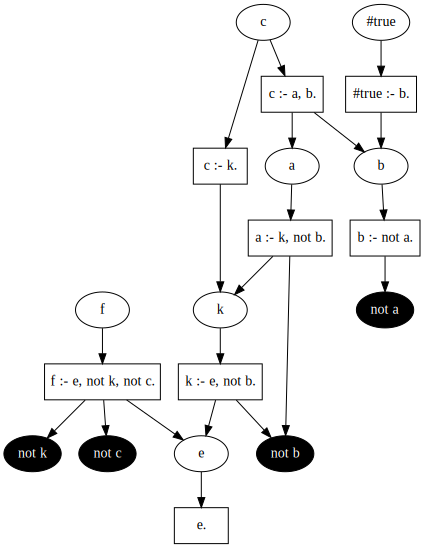

In [5]:
primal_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

rule(r1).
attr(node, r1, label, "a :- k, not b.").
edge((a, r1)).
edge((r1, k)).
edge((r1, -b)).

rule(r2).
attr(node, r2, label, "c :- a, b.").
edge((c, r2)).
edge((r2, a)).
edge((r2, b)).

rule(r3).
attr(node, r3, label, "c :- k.").
edge((c, r3)).
edge((r3, k)).

rule(r4).
attr(node, r4, label, "k :- e, not b.").
edge((k, r4)).
edge((r4, e)).
edge((r4, -b)).

rule(r5).
attr(node, r5, label, "e.").
edge((e, r5)).

rule(r6).
attr(node, r6, label, "b :- not a.").
edge((b, r6)).
edge((r6, -a)).

rule(r7).
attr(node, r7, label, "f :- e, not k, not c.").
edge((f, r7)).
edge((r7, e)).
edge((r7, -k)).
edge((r7, -c)).

rule(g1).
attr(node, g1, label, "#true :- b.").
edge((true, g1)).
edge((g1, b)).

"""

primal_graph = draw_graph([primal_graph_str, graph_encoding])['default']
primal_graph

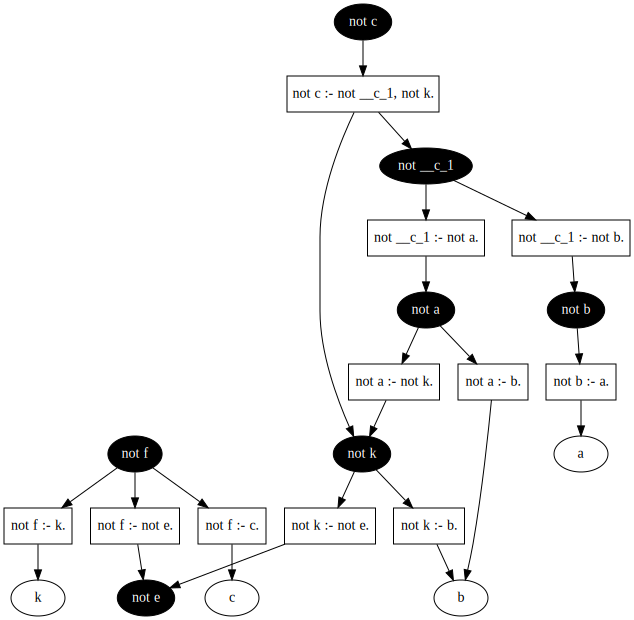

In [6]:
dual_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

neg_literal(-__c_1).
pos_neg(__c_1, -__c_1).

rule(d1).
attr(node, d1, label, "not a :- not k.").
edge((-a, d1)).
edge((d1, -k)).

rule(d2).
attr(node, d2, label, "not a :- b.").
edge((-a, d2)).
edge((d2, b)).

rule(d3).
attr(node, d3, label, "not c :- not __c_1, not k.").
edge((-c, d3)).
edge((d3, -__c_1)).
edge((d3, -k)).

rule(d4).
attr(node, d4, label, "not __c_1 :- not a.").
edge((-__c_1, d4)).
edge((d4, -a)).

rule(d5).
attr(node, d5, label, "not __c_1 :- not b.").
edge((-__c_1, d5)).
edge((d5, -b)).

rule(d6).
attr(node, d6, label, "not k :- not e.").
edge((-k, d6)).
edge((d6, -e)).

rule(d7).
attr(node, d7, label, "not k :- b.").
edge((-k, d7)).
edge((d7, b)).

rule(d8).
attr(node, d8, label, "not b :- a.").
edge((-b, d8)).
edge((d8, a)).

rule(d9).
attr(node, d9, label, "not f :- not e.").
edge((-f, d9)).
edge((d9, -e)).

rule(d10).
attr(node, d10, label, "not f :- k.").
edge((-f, d10)).
edge((d10, k)).

rule(d11).
attr(node, d11, label, "not f :- c.").
edge((-f, d11)).
edge((d11, c)).


"""

dual_graph = draw_graph([dual_graph_str, graph_encoding])['default']
dual_graph

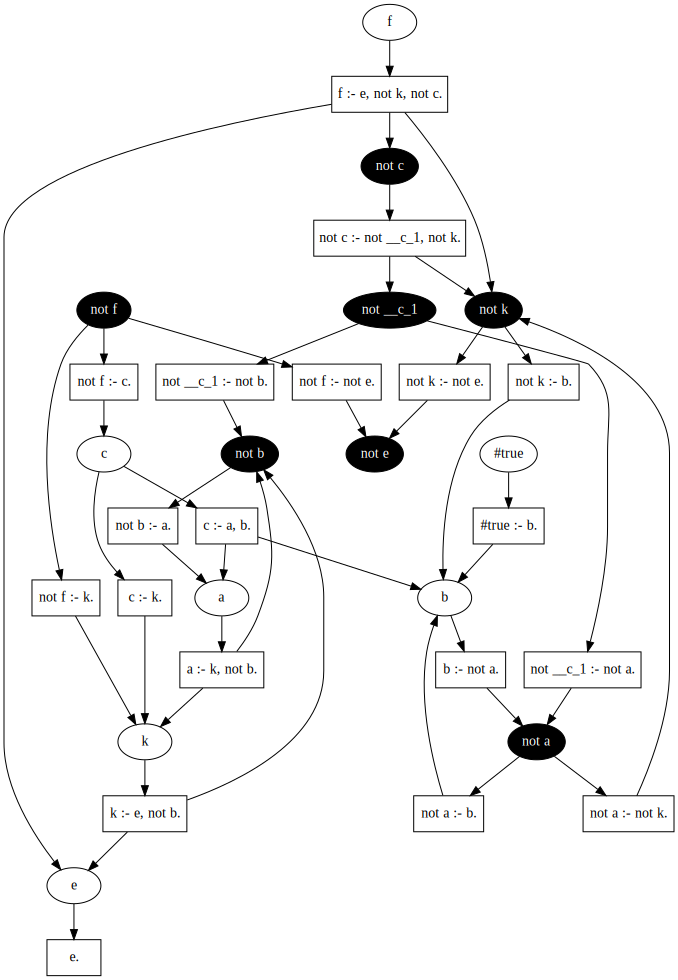

In [7]:
complete_graph = draw_graph([primal_graph_str, dual_graph_str, graph_encoding])['default']
complete_graph

As we can see most parts of the graph are irrelevant to our query. If we apply the normal form transformation with the body of the query we call the resulting graph a *residual* graph.

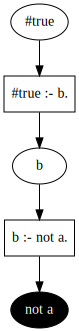

In [8]:
residual_primal_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).


rule(r6).
attr(node, r6, label, "b :- not a.").
edge((b, r6)).
edge((r6, -a)).

rule(g1).
attr(node, g1, label, "#true :- b.").
edge((true, g1)).
edge((g1, b)).

"""

residual_primal_graph = draw_graph([residual_primal_graph_str, graph_encoding])['default']
residual_primal_graph

This is simplifies the graph to only those rules which are necessary to derive the query (worst case: whole graph).

Naturally we can also apply the normal form transformation to the dual graph. We call the resulting graph the *residual dual* graph.

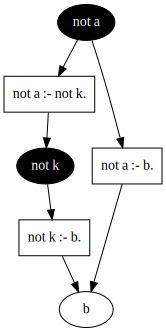

In [9]:
residual_dual_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

neg_literal(-__c_1).
pos_neg(__c_1, -__c_1).

rule(d1).
attr(node, d1, label, "not a :- not k.").
edge((-a, d1)).
edge((d1, -k)).

rule(d2).
attr(node, d2, label, "not a :- b.").
edge((-a, d2)).
edge((d2, b)).

rule(d7).
attr(node, d7, label, "not k :- b.").
edge((-k, d7)).
edge((d7, b)).

"""

residual_dual_graph = draw_graph([residual_dual_graph_str, graph_encoding])['default']
residual_dual_graph

If we combine both residual primal and residual dual graph we arrive at the *complete* residual graph.

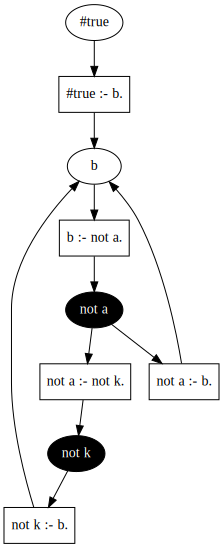

In [10]:
residual_graph = draw_graph([residual_primal_graph_str, residual_dual_graph_str, graph_encoding])['default']
residual_graph

Notice the similarities to the normal form.

To construct a proof we use coinduction. If we want to derive a literal we assume it to be true. We then have to prove the body of a rule which has the literal as head. In order to prove negative literals we use the dual rules.

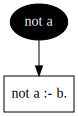

In [11]:
proof_dual_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

neg_literal(-__c_1).
pos_neg(__c_1, -__c_1).

rule(d2).
attr(node, d2, label, "not a :- b.").
edge((-a, d2)).


"""

proof_dual_graph = draw_graph([proof_dual_graph_str, graph_encoding])['default']
proof_dual_graph

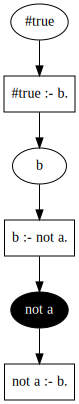

In [12]:
proof_tree = draw_graph([residual_primal_graph_str, proof_dual_graph_str, graph_encoding])['default']
proof_tree